In [1]:
#imports
import pandas as pd
import numpy as np
import nltk
import re
import os
from tqdm import tqdm, tqdm_pandas
#tqdm_pandas(tqdm())
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Sources
https://www.researchgate.net/figure/Average-daily-number-of-base-stations-visited-by-spammers-red-legitimate-customers_fig1_262330820
https://towardsdatascience.com/spam-detection-in-sms-messages-3322e03300f5

Could use other features as well:
* Number of links
* Number of emails
* Currency symbols
* numbers

# Data Analysis

In [2]:
import matplotlib.pyplot as plt 
import matplotlib as mpl

In [3]:
def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    return
setup_mpl()

The following analysis will investigate the nature of the spam/ham dataset. More specifically, we will look into how long the typical SMS is for each group respectively. Subsequently, we will investigate the amount of spelling mistakes present in each group.

In [80]:
from ast import literal_eval
df = pd.read_csv('../data/clean_spam.csv', encoding= "ISO-8859-1")
df.tokens = df.tokens.apply(literal_eval)
df.head()

,Unnamed: 0,label,text,tokens,str_tokens
0,0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazi, avail, bugi, n, gre...",go jurong point crazi avail bugi n great world...
1,1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, u, oni]",ok lar joke wif u oni
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entri, wkli, comp, win, fa, cup, final,...",free entri wkli comp win fa cup final tkt may ...
3,3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, earli, hor, u, c, alreadi, say]",u dun say earli hor u c alreadi say
4,4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goe, usf, live, around, though]",nah think goe usf live around though


In [81]:
df['len'] = df.tokens.str.len()
df_spam = df[df.label=='spam']
df_ham = df[df.label=='ham']

First let us investigate the proportion of ham and spam in the dataset:

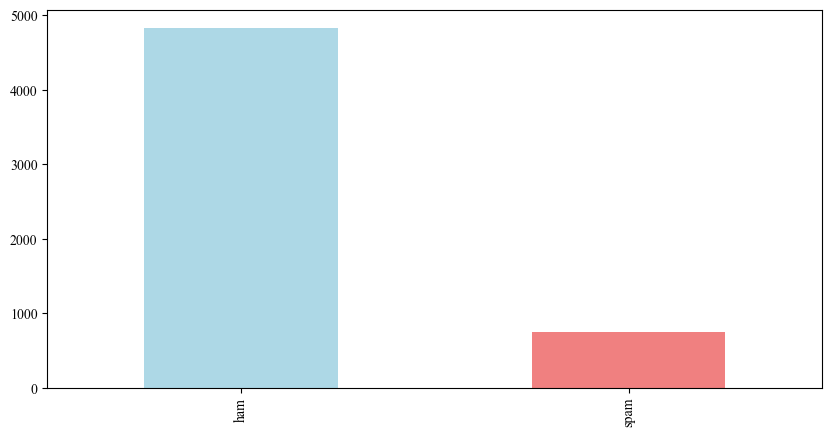

In [82]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
df.label.value_counts().plot(kind='bar', ax=ax, color=['lightblue', 'lightcoral'])
plt.show()

Notably, the dataset illustrated a significant class imbalance, which would probably have to be taken into account when training models for classification.

The following will analyse the length distribution of spam and ham mails:

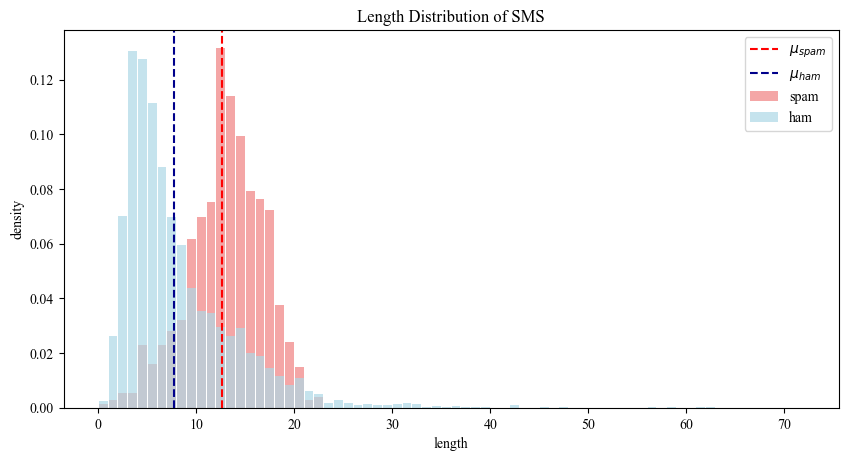

In [83]:

spam_len = list(df_spam.len.values)
ham_len = list(df_ham.len.values)

bins = np.arange(min(spam_len), max(spam_len), 1)
hist, edges = np.histogram(spam_len, bins=bins, density=True)
x = (edges[1:] + edges[:-1])/2
width = bins[1]-bins[0]

fig, ax = plt.subplots(1, figsize=(10,5), dpi=100)
ax.bar(x, hist, width=width*0.91, color='lightcoral', label='spam', alpha=0.7)
ax.set_ylabel("counts")
ax.set_xlabel("k")
ax.set_title("")

ax.axvline(np.mean(spam_len), c='red', label='$\mu_{spam}$', linestyle='dashed')
ax.axvline(np.mean(ham_len), c='darkblue', label='$\mu_{ham}$', linestyle='dashed')

bins = np.arange(min(ham_len), max(ham_len), 1)
hist, edges = np.histogram(ham_len, bins=bins, density=True)
x = (edges[1:] + edges[:-1])/2
width = bins[1]-bins[0]
ax.bar(x, hist, width=width*0.90, color='lightblue', label='ham', alpha=0.7)

ax.legend()
ax.set_ylabel("density")
ax.set_xlabel("length")
ax.set_title("Length Distribution of SMS") #TODO: maybe change to number of words

plt.show()

By visually inspecting the above figure, it appears that spam SMSes tend to have longer content than ham SMSes.

In [84]:
print(f'Mean of spam: {np.mean(spam_len)}')
print(f'Standard deviation of spam: {np.std(spam_len)}')
print()
print(f'Mean of ham: {np.mean(ham_len)}')
print(f'Standard deviation of ham: {np.std(ham_len)}')

Mean of spam: 12.576974564926372
Standard deviation of spam: 3.88149834483534

Mean of ham: 7.692849740932642
Standard deviation of ham: 6.1017079629809485


Furthermore, the following will investigate the proportion of spelling mistakes in each group respectively.

In [85]:
from spellchecker import SpellChecker
import re
import nltk
from tqdm import tqdm

tqdm.pandas()

def find_misspelled(row):
    #TODO: add words that are not misspelled but not in dictionary e.g. nokia
    text = row.text.lower()
    spell = SpellChecker()
    words = nltk.tokenize.word_tokenize(text)
    #re_pattern = '[a-z]+'
    #re_pattern = '[a-z]{2,}'
    #words = re.findall(re_pattern, text)
    misspelled = [word for word in spell.unknown(words) if str(word) not in ['nan']]
    return misspelled

In [86]:
df['misspelled'] = df.progress_apply(lambda row: find_misspelled(row), axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5572/5572 [07:48<00:00, 11.88it/s]


In [87]:
df['misspelled_size'] = df['misspelled'].apply(lambda x: len(x))

In [88]:
df_spam = df[df.label=='spam']
df_ham = df[df.label=='ham']

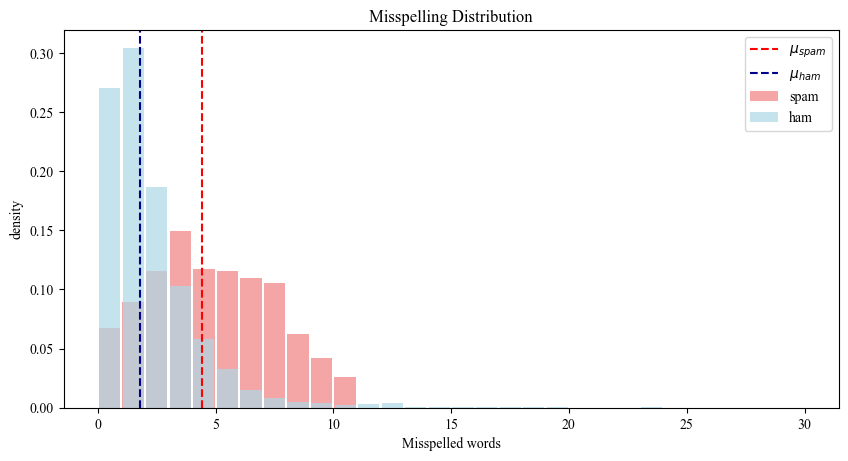

In [89]:
spam_len = list(df_spam.misspelled_size.values)
ham_len = list(df_ham.misspelled_size.values)

bins = np.arange(min(spam_len), max(spam_len), 1)
hist, edges = np.histogram(spam_len, bins=bins, density=True)
x = (edges[1:] + edges[:-1])/2
width = bins[1]-bins[0]

fig, ax = plt.subplots(1, figsize=(10,5), dpi=100)
ax.bar(x, hist, width=width*0.91, color='lightcoral', label='spam', alpha=0.7)
ax.set_ylabel("counts")
ax.set_xlabel("k")
ax.set_title("")

ax.axvline(np.mean(spam_len), c='red', label='$\mu_{spam}$', linestyle='dashed')
ax.axvline(np.mean(ham_len), c='darkblue', label='$\mu_{ham}$', linestyle='dashed')

bins = np.arange(min(ham_len), max(ham_len), 1)
hist, edges = np.histogram(ham_len, bins=bins, density=True)
x = (edges[1:] + edges[:-1])/2
width = bins[1]-bins[0]
ax.bar(x, hist, width=width*0.90, color='lightblue', label='ham', alpha=0.7)

ax.legend()
ax.set_ylabel("density")
ax.set_xlabel("Misspelled words")
ax.set_title("Misspelling Distribution")

plt.show()

In [90]:
freqdist_spam = nltk.FreqDist(df[df.label=='spam'].misspelled.explode().values)
freqdist_ham = nltk.FreqDist(df[df.label=='ham'].misspelled.explode().values)

In [91]:
freqdist_spam = {k: v for k, v in sorted(freqdist_spam.items(), key=lambda item: item[1], reverse=True)  if not type(k) == float}
freqdist_ham = {k: v for k, v in sorted(freqdist_ham.items(), key=lambda item: item[1], reverse=True)  if not type(k) == float}

In [92]:
freqdist_spam

{'txt': 147,
 't': 68,
 "'s": 59,
 'c': 49,
 'nokia': 49,
 'cs': 41,
 'ï¿½1000': 35,
 '150ppm': 34,
 'r': 29,
 'msg': 27,
 '150p': 27,
 '16+': 25,
 '1st': 25,
 'sms': 23,
 'ï¿½100': 22,
 'ï¿½1.50': 20,
 'ï¿½5000': 20,
 'ï¿½2000': 20,
 '2nd': 20,
 'http': 19,
 '18+': 19,
 'ï¿½500': 19,
 'u.': 18,
 'unsubscribe': 18,
 '12hrs': 17,
 'todays': 17,
 'pobox': 16,
 'mobileupd8': 16,
 'wk': 16,
 '150p/msg': 15,
 'wkly': 14,
 'freemsg': 14,
 '10p': 14,
 'ï¿½250': 14,
 "n't": 13,
 'ltd': 13,
 'txts': 13,
 "''": 12,
 'un-redeemed': 12,
 'xxx': 11,
 'motorola': 11,
 'ï¿½2,000': 11,
 'txting': 10,
 'x': 10,
 'ldn': 10,
 'ts': 10,
 'pls': 10,
 'ntt': 10,
 "'ve": 10,
 'std': 9,
 'ï¿½200': 9,
 'ï¿½150': 9,
 'm.': 9,
 's.': 9,
 'i.': 9,
 'ï¿½350': 9,
 'www.getzed.co.uk': 9,
 '10p/min': 9,
 'ï¿½800': 9,
 'b': 9,
 'n': 9,
 '..': 9,
 'wap': 8,
 'sp': 8,
 'msgs': 8,
 'freephone': 8,
 'special-call': 8,
 'u-find': 8,
 'cd': 8,
 'hg/suite342/2lands': 8,
 'custcare': 8,
 '25p': 8,
 'no1': 8,
 'bt-national-rat

In [93]:
freqdist_ham

{'...': 711,
 '..': 425,
 "'s": 381,
 "'m": 353,
 "n't": 281,
 'lt': 242,
 'gt': 242,
 "'ll": 222,
 'r': 115,
 'n': 112,
 "''": 111,
 'ï¿½_': 97,
 'k': 93,
 'pls': 91,
 "'re": 83,
 "'ve": 77,
 'c': 60,
 'b': 54,
 'ï¿½ï¿½': 54,
 'msg': 52,
 'd': 51,
 'thk': 47,
 '....': 46,
 'liao': 37,
 'v': 36,
 'aight': 33,
 'ok.': 33,
 'didnt': 30,
 'leh': 29,
 'afternoon': 28,
 'tmr': 27,
 'i.ll': 26,
 's': 26,
 'x': 25,
 "'d": 25,
 'juz': 24,
 'tv': 24,
 'plz': 21,
 'sch': 20,
 'sms': 18,
 'gd': 18,
 'u.': 17,
 'chikku': 17,
 'bt': 17,
 'neva': 17,
 'boytoy': 16,
 'smth': 15,
 'xxx': 15,
 'oredi': 15,
 'g': 15,
 'hmm': 14,
 'ni8': 13,
 'fr': 13,
 'dnt': 13,
 'bslvyl': 13,
 'frm': 13,
 'knw': 13,
 'ï¿½ï¿½_': 13,
 'mayb': 13,
 'nt': 13,
 'w': 13,
 'frnds': 12,
 'askd': 12,
 'm': 12,
 'gr8': 12,
 'txt': 12,
 'abiola': 11,
 'hmmm': 11,
 'mrng': 11,
 'bcoz': 11,
 'pm': 11,
 'th': 11,
 '1st': 11,
 'usf': 10,
 '2nd': 10,
 'xx': 10,
 'k.': 10,
 'muz': 10,
 'mr': 10,
 'mm': 10,
 'frnd': 9,
 'doesnt': 9,
 '

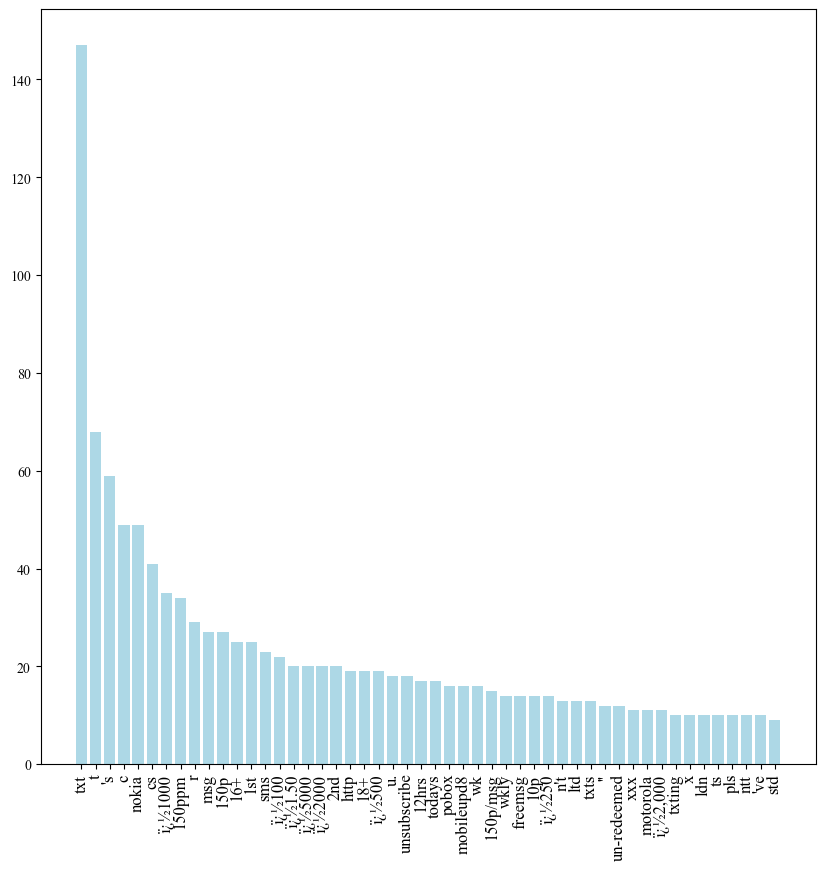

In [94]:
k=50
fig, ax = plt.subplots(figsize=(10,10),dpi=100)
ax.bar(list(freqdist_spam.keys())[:k], list(freqdist_spam.values())[:k], color='lightblue')
plt.xticks(rotation=90, size=12)
plt.show()

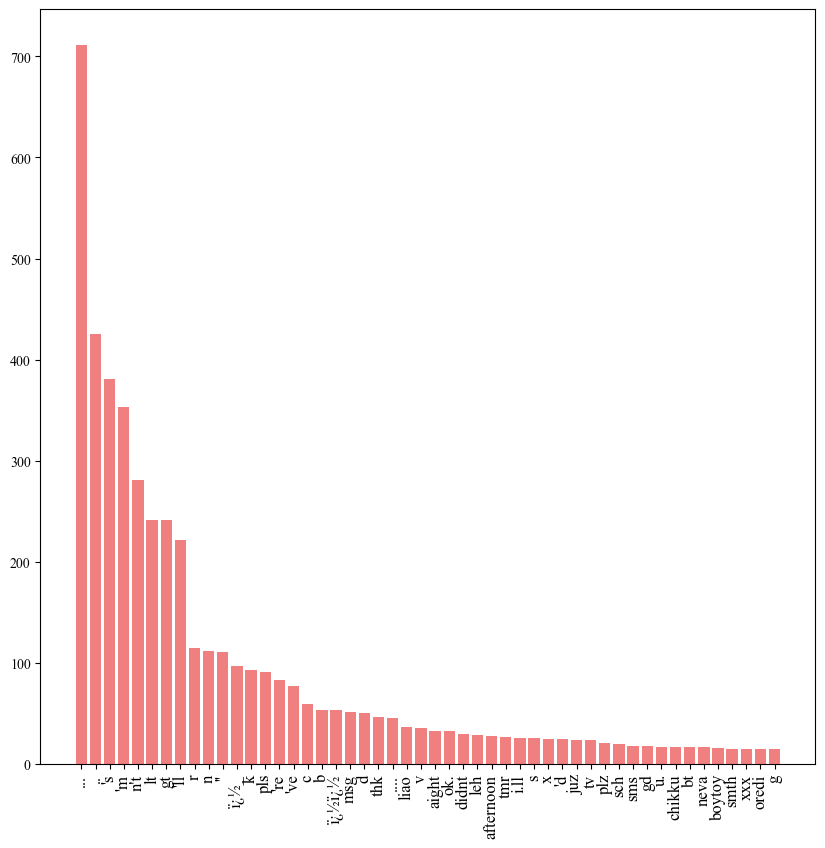

In [95]:
k=50
fig, ax = plt.subplots(figsize=(10,10),dpi=100)
ax.bar(list(freqdist_ham.keys())[:k], list(freqdist_ham.values())[:k], color='lightcoral')
plt.xticks(rotation=90, size=12)
plt.show()

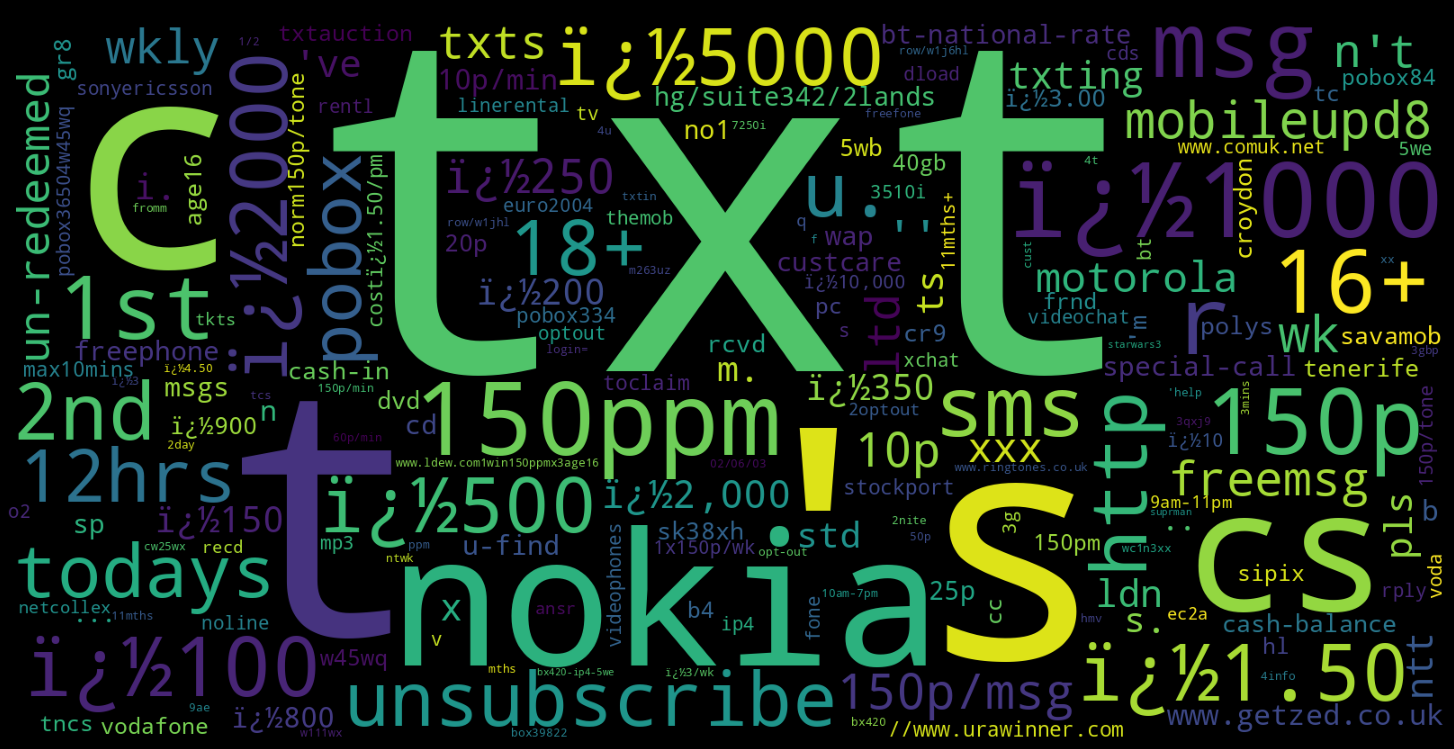

In [96]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800)
spam_cloud = wordcloud.generate_from_frequencies(frequencies=freqdist_spam)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(spam_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Misspelled words (spam)')
plt.show()

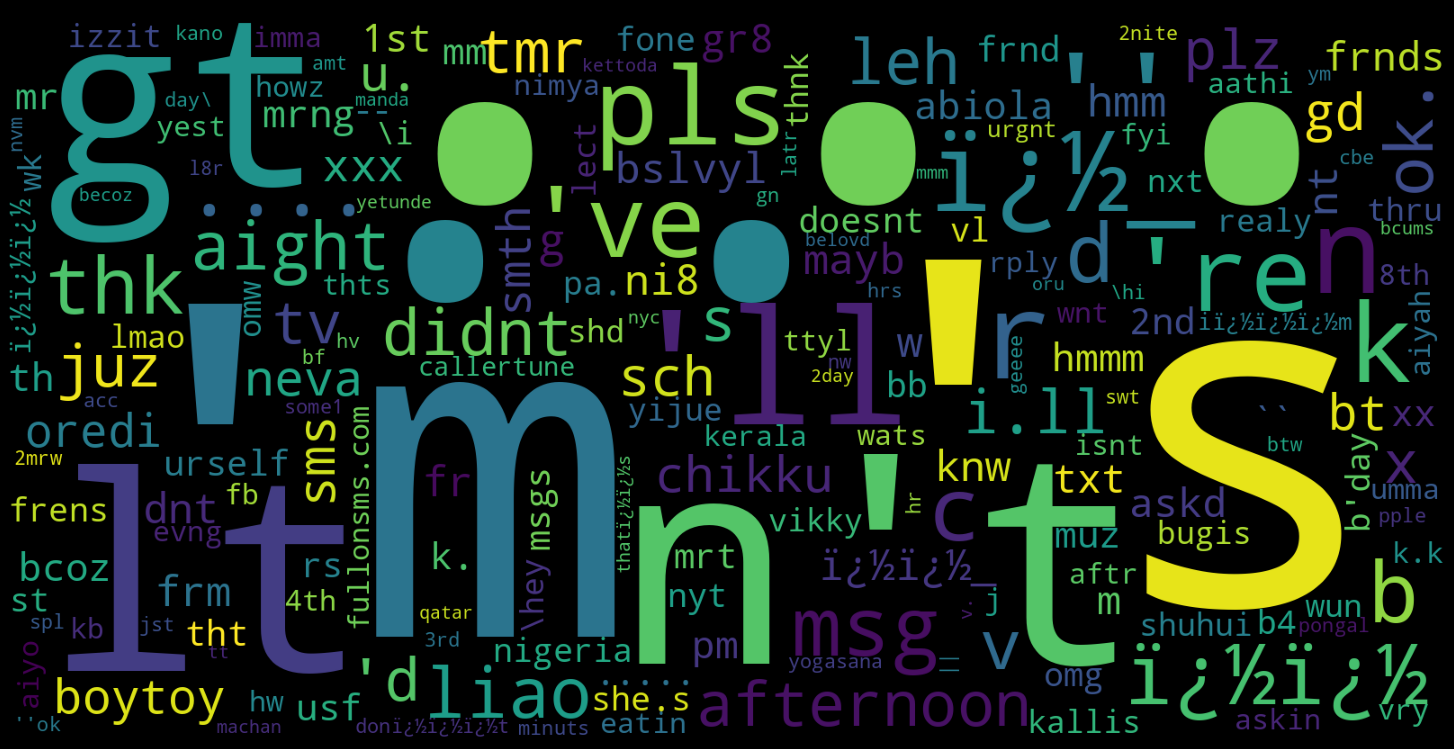

In [97]:
wordcloud = WordCloud(width=1600, height=800)
ham_cloud = wordcloud.generate_from_frequencies(frequencies=freqdist_ham)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(ham_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Misspelled words (ham)')
plt.show()

TODO: Data cleaning - remove NANS

# Text preprocessing

In [25]:
PATH = "../data/spam.csv"

In [26]:
df = pd.read_csv(PATH)[['v1','v2']]
df = df.rename(columns={'v1': 'label', 'v2': 'text'})

In [27]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [28]:
label = df['label'].values
text = df['text'].values
label, text

(array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype=object),
 array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
        'Ok lar... Joking wif u oni...',
        "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
        ..., 'Pity, * was in mood for that. So...any other suggestions?',
        "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free",
        'Rofl. Its true to its name'], dtype=object))

In [119]:
#1
#Create preprocessing function and apply it to the data


#Importing two different normalization methods
porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()

def preprocess(text):
    #Common english stop words
    stop_words = set(stopwords.words('english'))
    #Removing urls
    #text = re.sub(r'http\S+', '', text)
    #Tokenize using nltk
    word_tokens = word_tokenize(text.lower())
    #removing none letter characters and stop words
    filtered_sentence = [w for w in word_tokens if w not in stop_words and w.isalpha()]
    #Conduct stemming
    processed_text = [porter.stem(t) for t in filtered_sentence]
    return processed_text
    
df['tokens'] = [preprocess(x) for x in tqdm(df['text'])]
df['str_tokens'] = [' '.join(preprocess(x)) for x in tqdm(df['text'])]

100%|████████████████████████████████████████████████████████████████████████| 5572/5572 [00:04<00:00, 1216.30it/s]


In [88]:
df.head()

,label,text,tokens,str_tokens
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazi, avail, bugi, n, gre...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, u, oni]",ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entri, wkli, comp, win, fa, cup, final,...",free entri wkli comp win fa cup final tkt may ...
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, earli, hor, u, c, alreadi, say]",u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goe, usf, live, around, though]",nah think goe usf live around though


In [32]:
df.to_csv('../data/clean_spam.csv', index=False)

In [20]:
from ast import literal_eval
df = pd.read_csv('../data/clean_spam.csv')
df.tokens = df.tokens.apply(literal_eval)
df.head()

,Unnamed: 0,label,text,tokens,str_tokens
0,0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazi, avail, bugi, n, gre...",go jurong point crazi avail bugi n great world...
1,1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, u, oni]",ok lar joke wif u oni
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entri, wkli, comp, win, fa, cup, final,...",free entri wkli comp win fa cup final tkt may ...
3,3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, earli, hor, u, c, alreadi, say]",u dun say earli hor u c alreadi say
4,4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goe, usf, live, around, though]",nah think goe usf live around though


# TFIDF (Sklearn edition)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import umap
import umap.plot

In [31]:
def dummy_fun(doc):
    return doc

#tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words='english')
#tfidf_word_doc_matrix = tfidf_vectorizer.fit_transform(dataset.data)

In [32]:
vectorizer = TfidfVectorizer(analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)
vecs = vectorizer.fit_transform(df['tokens'])
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
TDM = pd.DataFrame(lst1, columns=feature_names).dropna()
TDM

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,...,zebra,zed,zero,zhong,zindgi,zoe,zogtoriu,zoom,zouk,zyada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# WordCloud

In [501]:
from wordcloud import WordCloud

In [510]:
spam_idx = (df['label']=='spam').values
ham_idx = (df['label']=='ham').values

In [527]:
spam_cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(TDM[df.label=='spam'].T.sum(axis=1))
ham_cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(TDM[df.label=='ham'].T.sum(axis=1))

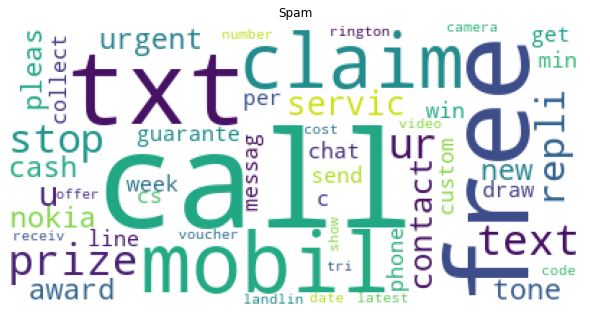

In [530]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(spam_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Spam")
plt.show()

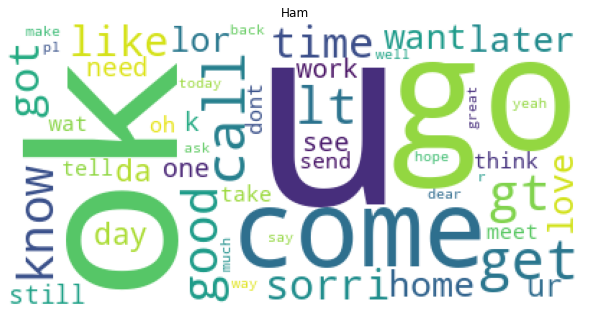

In [531]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(ham_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Ham")
plt.show()

# UMAP

In [48]:
import umap.umap_ as umap

In [49]:
tfidf_embedding = umap.UMAP(metric='cosine', verbose=True).fit(vecs)

UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0, metric='cosine',
     verbose=True)
Construct fuzzy simplicial set
Tue Nov  8 16:22:25 2022 Finding Nearest Neighbors
Tue Nov  8 16:22:25 2022 Building RP forest with 9 trees
Tue Nov  8 16:22:25 2022 metric NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	 8  /  12
	 9  /  12
	Stopping threshold met -- exiting after 9 iterations
Tue Nov  8 16:22:39 2022 Finished Nearest Neighbor Search
Tue Nov  8 16:22:39 2022 Construct embedding


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 1851 edges.
It has only fully disconnected 68 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Nov  8 16:22:46 2022 Finished embedding


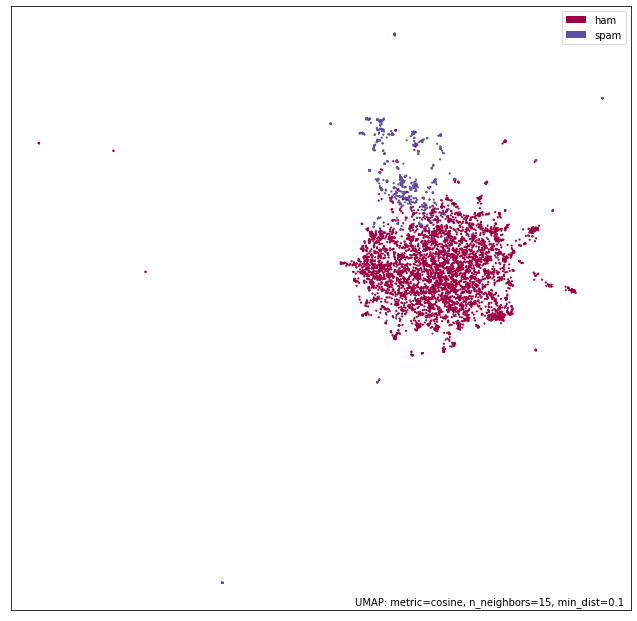

In [50]:
import umap.plot
fig = umap.plot.points(tfidf_embedding, labels=df['label'])

# PCA

In [123]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [127]:
pca = PCA(n_components=10)
pca.fit(vecs.todense().T)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


PCA(n_components=10)

In [128]:
pca.components_.shape

(10, 5572)

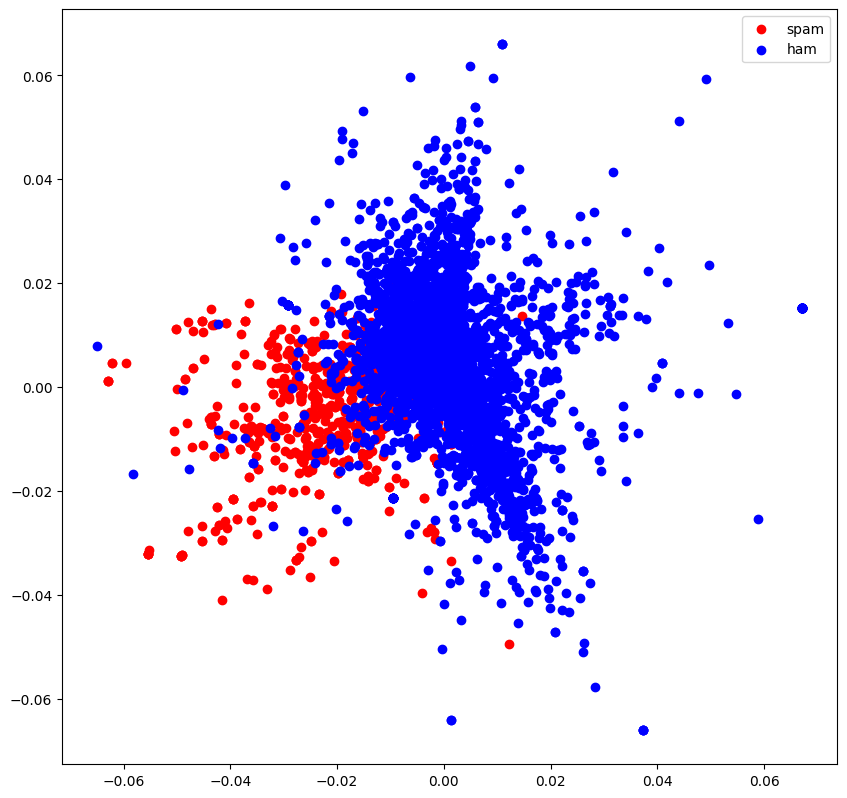

In [170]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
spam_idx = df['label']=='spam'
ham_idx = df['label']=='ham'
ax.scatter(pca.components_[4,:][spam_idx], pca.components_[5,:][spam_idx], c='red', label='spam')
ax.scatter(pca.components_[4,:][ham_idx], pca.components_[5,:][ham_idx], c='blue', label='ham')
ax.legend()
plt.show()

# T-SNE

In [135]:
from sklearn.manifold import TSNE

In [145]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=100, verbose=True).fit_transform(vecs)
X_embedded.shape

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5572 samples in 0.001s...
[t-SNE] Computed neighbors for 5572 samples in 1.124s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5572
[t-SNE] Computed conditional probabilities for sample 2000 / 5572
[t-SNE] Computed conditional probabilities for sample 3000 / 5572
[t-SNE] Computed conditional probabilities for sample 4000 / 5572
[t-SNE] Computed conditional probabilities for sample 5000 / 5572
[t-SNE] Computed conditional probabilities for sample 5572 / 5572
[t-SNE] Mean sigma: 0.501598
[t-SNE] KL divergence after 250 iterations with early exaggeration: 125.357422
[t-SNE] KL divergence after 1000 iterations: 3.184763


(5572, 2)

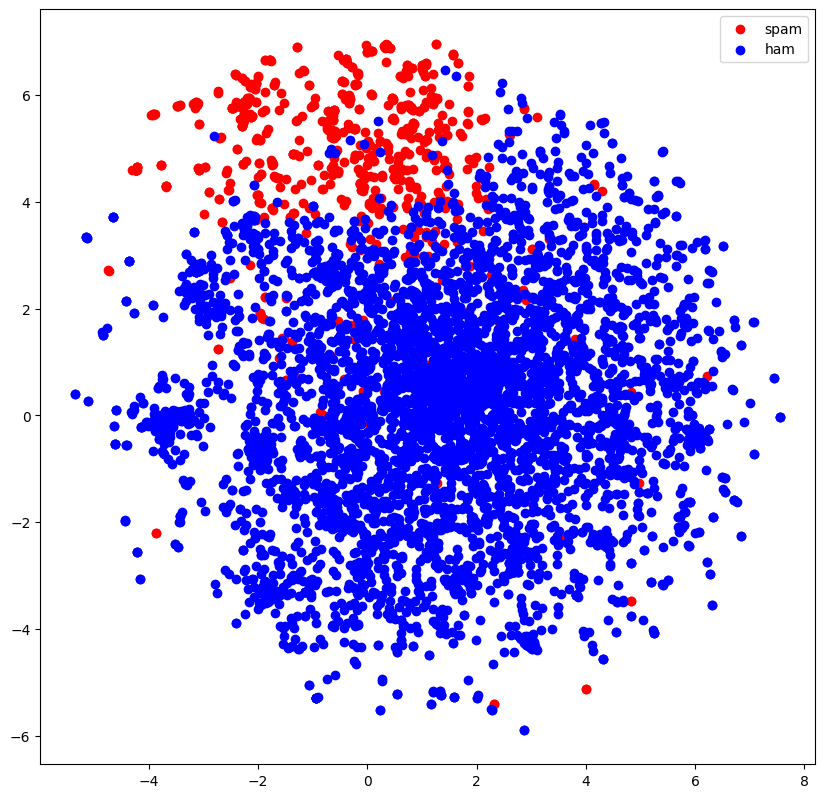

In [146]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
ax.scatter(X_embedded.T[0,:][spam_idx], X_embedded.T[1,:][spam_idx], c='red', label='spam')
ax.scatter(X_embedded.T[0,:][ham_idx], X_embedded.T[1,:][ham_idx], c='blue', label='ham')
ax.legend()
plt.show()

# Clustering

In [216]:
X = vecs.todense()

In [244]:
X.shape

(5572, 5834)

In [210]:
np.random.seed(1)
min_, max_ = np.min(X, axis=0), np.max(X, axis=0)
centroids = np.array([uniform(min_, max_) for _ in range(2)]).squeeze()

In [215]:
min_.shape, max_.shape

((1, 5834), (1, 5834))

In [226]:
from numpy.random import uniform
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
def kmeans(X, k, random_state=42, early_stopping=10):
    #Init centroids uniformly
    np.random.seed(random_state)
    min_, max_ = np.min(X, axis=0), np.max(X, axis=0)
    centroids = np.array([uniform(min_, max_) for _ in range(k)]).squeeze()
    #initial placeholder
    prev_centroids = np.zeros(centroids.shape)
    #Run until convergence
    itr = 1
    while not np.allclose(prev_centroids, centroids):
        print(f'Iteration number: {itr}')
        dists=((np.expand_dims(X, 1)-centroids+1e-06)**2).sum(-1)**0.5 #Using broadcasting to compute dists
        assignments = dists.argmin(axis=1)
        prev_centroids = centroids.copy()
        #Update centroid position
        for idx in range(k):
            centroids[idx, :] = X[np.where(assignments==idx)].mean(axis=0)
        itr += 1
        if itr == early_stopping:
            break
    return assignments, centroids

In [227]:
assign, centroids = kmeans(X, 2, random_state=1)

Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9


In [245]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42).fit(X)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [248]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

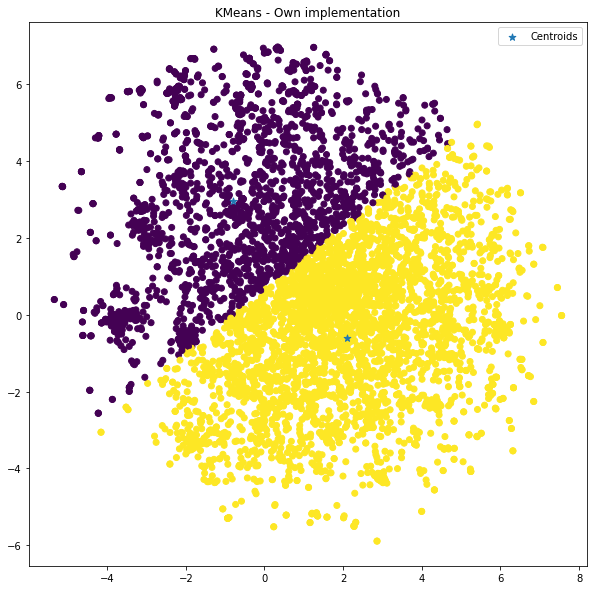

In [169]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X[:,0], X[:,1], c=assign)
ax.scatter(centroids[:,0], centroids[:,1],s=50,marker='*', label='Centroids')
#ax.plot([],[],c='white', label=f'Davies Bouldin index = {davies_bouldin_score(X, assign)}')
ax.set_title("KMeans - Own implementation")
ax.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


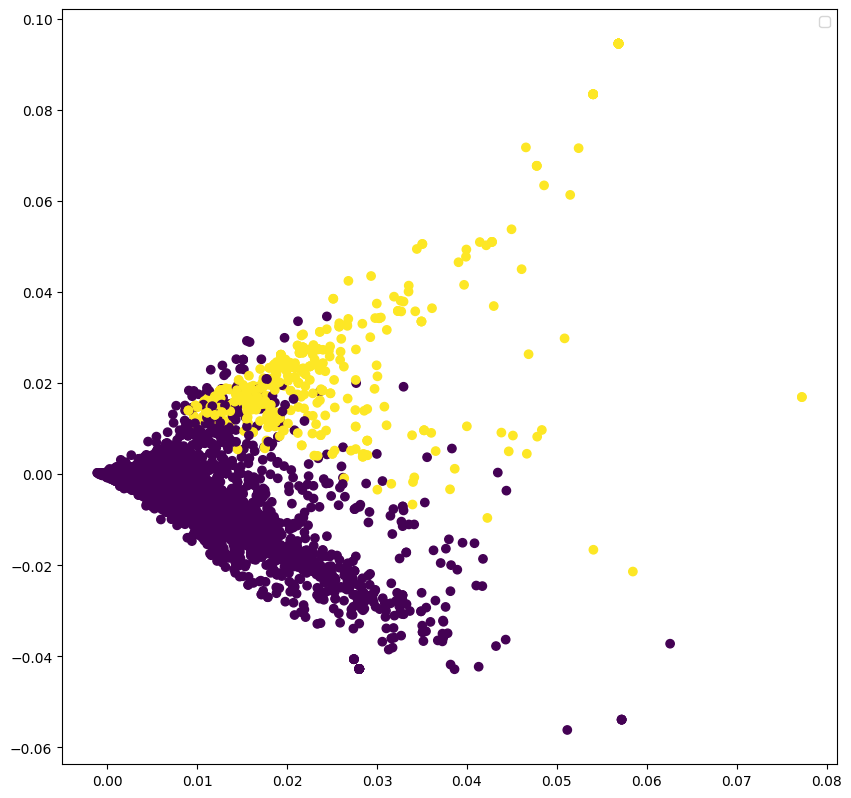

In [240]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
ax.scatter(pca.components_[0,:], pca.components_[1,:], c=kmeans.labels_)
ax.legend()
plt.show()

In [241]:
from sklearn.metrics import adjusted_rand_score

In [250]:
adjusted_rand_score(df['label'], kmeans.labels_)

0.3639285149173757

# Classification

## Random Forest

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [33]:
x = vecs.todense()
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=1/3, random_state=42)

In [34]:
clf = RandomForestClassifier().fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(f1_score(test.label, y_hat, pos_label='spam'))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.8860759493670886

In [536]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier()
scores = cross_val_score(clf, x, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy

0.97 accuracy with a standard deviation of 0.00


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy

0.86 accuracy with a standard deviation of 0.00


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


# Naive Bayes
## Bernouille

$$p(C_{k}|x_{1},...,x_{n}) \propto p(C_{k})\prod_{i=1}^{n}p(x_{i}|C_{i})$$
$$\hat{y}=\underset{k\in \{1,..,K\}}{argmax}=p(C_{k})\prod_{i=1}^{n}p(x_{i}|C_{i})$$


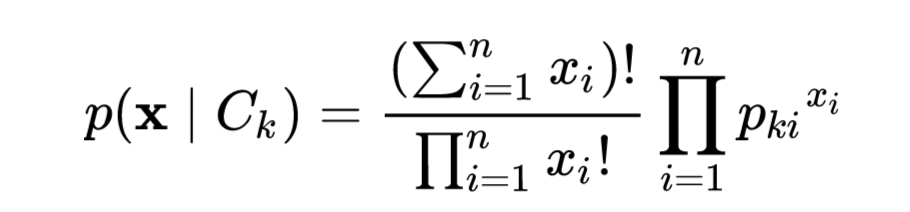

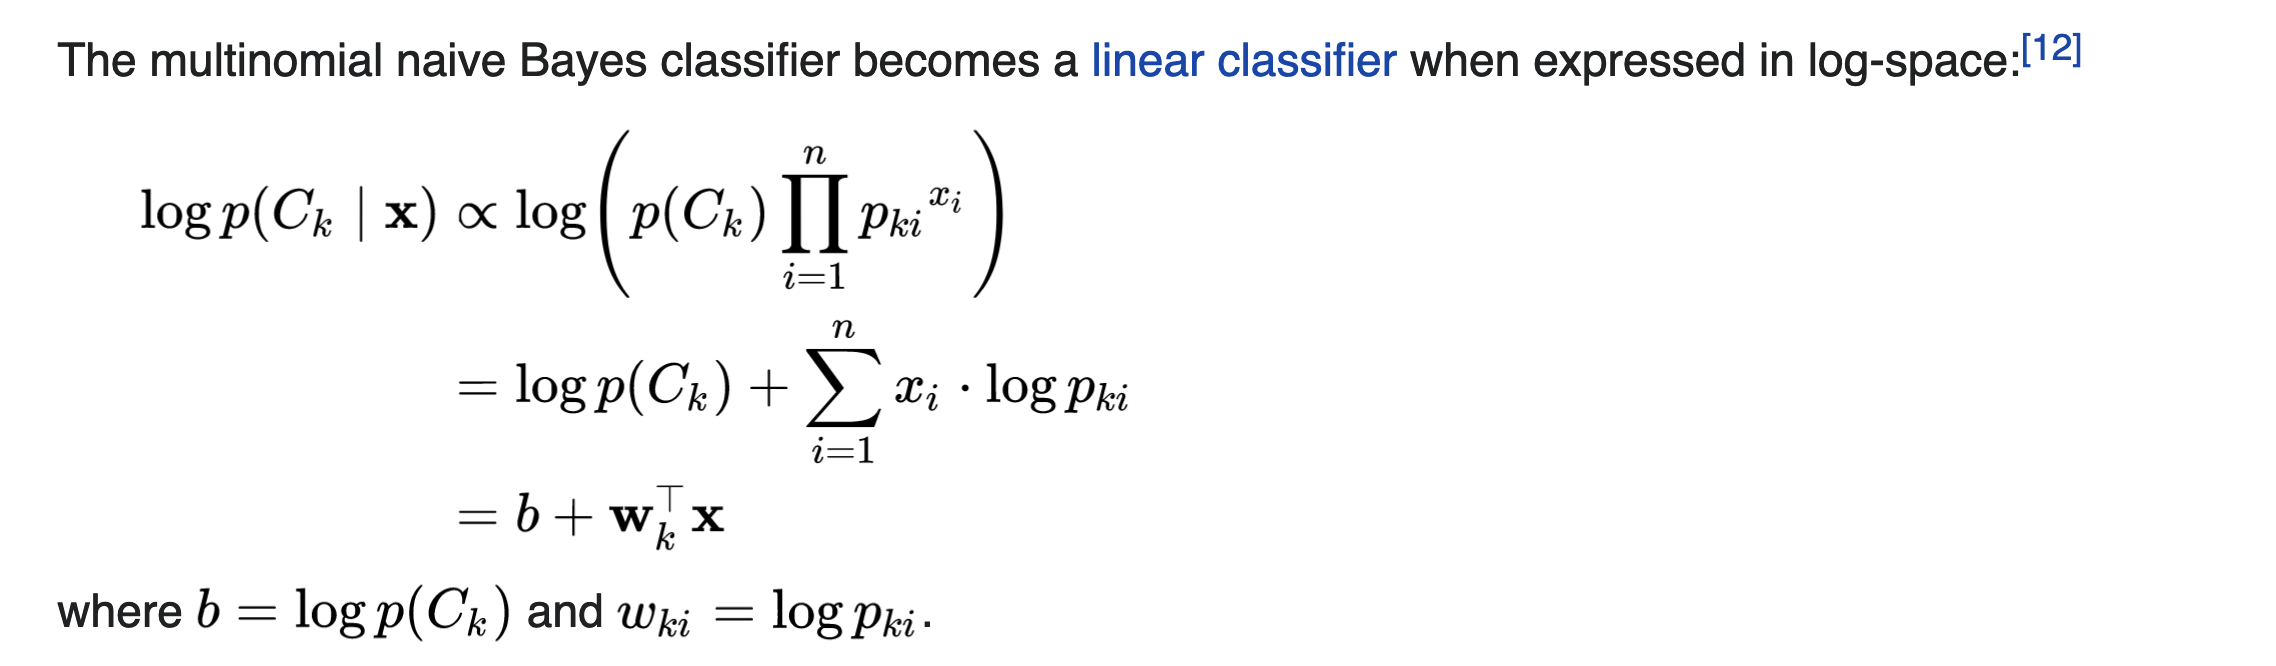

https://web.stanford.edu/class/cs124/lec/naivebayes2021.pdf

In [8]:
vectorizer = CountVectorizer(analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)
vecs = vectorizer.fit_transform(df['tokens'])
feature_names = vectorizer.get_feature_names_out()

In [9]:
porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()

def preprocess(text):
    #Common english stop words
    stop_words = set(stopwords.words('english'))
    #Removing urls
    #text = re.sub(r'http\S+', '', text)
    #Tokenize using nltk
    word_tokens = word_tokenize(text.lower())
    #removing none letter characters and stop words
    filtered_sentence = [w for w in word_tokens if w not in stop_words and w.isalpha()]
    #Conduct stemming
    processed_text = [porter.stem(t) for t in filtered_sentence]
    return processed_text

In [10]:
from tqdm import tqdm

class naiveBayes:
    def __init__(self, embedding, labels, vocab):
        self.vocab_token_map = dict(zip([i for i in range(len(vocab))], vocab))
        self.classes = np.unique(labels) #ham, spam
        self.labels = labels
        self.embedding = embedding
        self.vocab = vocab

    def train(self):
        Ntot = self.embedding.shape[1]
        logprior = {}
        loglikelihood = {}
        #count = {}
        for class_ in self.classes:
            count = {}
            Nc = sum(self.labels==class_)
            logprior[class_] = np.log(Nc/Ntot)
            docs_class = self.embedding[self.labels==class_, :]
            
            for idx, word in tqdm(enumerate(self.vocab)):
                #count[(word, class_)] = docs_class[:, idx].sum()
                count[word] = docs_class[:, idx].sum()
                #counts = docs_class[:, idx].sum()
                
                
            for jdx, word in enumerate(self.vocab):
                #loglikelihood[(word, class_)] = np.log( (count[(word, class_)] + 1 )/ ())
                loglikelihood[(word, class_)] = np.log((count[word] + 1) / (sum(count.values()) + 1))
        
        self.logprior = logprior
        self.loglikelihood = loglikelihood
    
    def keywithmaxval(self, d):
        v = list(d.values())
        k = list(d.keys())
        return k[v.index(max(v))]
    
    
    def predict(self, doc):
        tokens = preprocess(doc)
        score = {class_: 0 for class_ in self.classes}
        for class_ in self.classes:
            score[class_] = self.logprior[class_]
            for token in tokens:
                #Disregarding terms not in vocab
                try:
                    score[class_] += self.loglikelihood[(token, class_)]
                except Exception as e:
                    pass
                    #print(f'the following word is out of vocab: {e}')
                    
        
        return self.keywithmaxval(score)

        

In [51]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
#Hold out validation

vectorizer = CountVectorizer(analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

train, test = train_test_split(df, test_size=0.2)#, stratify=df.label)

y_train = train['label']
x_train = vectorizer.fit_transform(train['tokens'])

feature_names = vectorizer.get_feature_names_out()

model = naiveBayes(x_train, y_train, feature_names) #TODO: How to ensure no data leakage

In [22]:
model.train()

5178it [00:01, 3338.17it/s]
5178it [00:00, 6277.24it/s]


In [23]:
y_hat = []
for (idx, row) in test.iterrows():
    y_hat.append(model.predict(row.text))

In [24]:
print(f'Accuracy: {sum(y_hat == test.label)/len(test.label):.3f}')

Accuracy: 0.968


In [25]:
from sklearn.metrics import f1_score

In [26]:
f1_score(test.label, y_hat, pos_label='spam')

0.8860759493670886

## Naive Bayes is Just Linear Algebra

In [ ]:
class naiveBayes:
    '''
    b + w_kT x
    b   = log(p(C_k))
    w_ki = log(pki)
    '''
    
    def __init__(self):
        
        
        
    def train():
        
        
        return w
    
    
    def predict():
        
        
        return 

In [ ]:
class naiveBayes:
    def __init__(self, embedding, labels, vocab):
        self.vocab_token_map = dict(zip([i for i in range(len(vocab))], vocab))
        self.classes = np.unique(labels) #ham, spam
        self.labels = labels
        self.embedding = embedding
        self.vocab = vocab

    def train(self):
        Ntot = self.embedding.shape[1]
        logprior = {}
        loglikelihood = {}
        #count = {}
        for class_ in self.classes:
            count = {}
            Nc = sum(self.labels==class_)
            logprior[class_] = np.log(Nc/Ntot)
            docs_class = self.embedding[self.labels==class_, :]
            
            for idx, word in tqdm(enumerate(self.vocab)):
                #count[(word, class_)] = docs_class[:, idx].sum()
                count[word] = docs_class[:, idx].sum()
                #counts = docs_class[:, idx].sum()
                
                
            for jdx, word in enumerate(self.vocab):
                #loglikelihood[(word, class_)] = np.log( (count[(word, class_)] + 1 )/ ())
                loglikelihood[(word, class_)] = np.log((count[word] + 1) / (sum(count.values()) + 1))
        
        self.logprior = logprior
        self.loglikelihood = loglikelihood
    
    def keywithmaxval(self, d):
        v = list(d.values())
        k = list(d.keys())
        return k[v.index(max(v))]
    
    
    def predict(self, doc):
        tokens = preprocess(doc)
        score = {class_: 0 for class_ in self.classes}
        for class_ in self.classes:
            score[class_] = self.logprior[class_]
            for token in tokens:
                #Disregarding terms not in vocab
                try:
                    score[class_] += self.loglikelihood[(token, class_)]
                except Exception as e:
                    pass
                    #print(f'the following word is out of vocab: {e}')
                    
        
        return self.keywithmaxval(score)

## Gaussian

In [40]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(x_train, y_train)

testing_data = vectorizer.transform(test.tokens)
y_test = test.label
predictions = naive_bayes.predict(testing_data)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {}'.format(precision_score(y_test, predictions,  pos_label='spam')))
print('Recall score: {}'.format(recall_score(y_test, predictions,  pos_label='spam')))
print('F1 score: {}'.format(f1_score(y_test, predictions,  pos_label='spam')))

Accuracy score: 0.9739910313901345
Precision score: 0.910958904109589
Recall score: 0.8926174496644296
F1 score: 0.9016949152542374


In [38]:
test


,Unnamed: 0,label,text,tokens,str_tokens
981,981,ham,Reckon need to be in town by eightish to walk ...,"[reckon, need, town, eightish, walk, carpark]",reckon need town eightish walk carpark
1688,1688,ham,Nan sonathaya soladha. Why boss?,"[nan, sonathaya, soladha, boss]",nan sonathaya soladha boss
4242,4242,ham,Okie...,[oki],oki
411,411,ham,Cos i want it to be your thing,"[co, want, thing]",co want thing
3323,3323,ham,I don wake since. I checked that stuff and saw...,"[wake, sinc, check, stuff, saw, true, avail, s...",wake sinc check stuff saw true avail space pl ...
...,...,...,...,...,...
4697,4697,ham,Don no da:)whats you plan?,"[da, what, plan]",da what plan
3098,3098,ham,Ok... I din get ur msg...,"[ok, din, get, ur, msg]",ok din get ur msg
3383,3383,spam,FREE MSG:We billed your mobile number by mista...,"[free, msg, bill, mobil, number, mistak, short...",free msg bill mobil number mistak shortcod cal...
3620,3620,ham,That means from february to april i'll be gett...,"[mean, februari, april, get, place, stay, hust...",mean februari april get place stay hustl back ...
